In [1]:
%matplotlib inline

import csv
import os
import requests
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from bs4 import BeautifulSoup
from datetime import datetime
from requests import get
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from urllib.request import urlopen

sns.set(color_codes=True)

In [2]:
os.getcwd()

'C:\\Users\\Akuma2099\\MachineLearning\\QTW_Project_2'

# Introduction

The Credit Union Cherry Blossom Ten Mile Run is an annual run held in Washington, D.C. that brings together credit unions from across the country with a shared vision of fund raising and helping children. The proceeds from donations, registration fees, and merchandise sales from the event support Children’s Hospitals that belong to the non-profit Children's Miracle Network.

Since the innuagural run in 1973, hundreds of thousands of runners from around the world have participated in the event. The registration of each runners name, age, hometown, and race times provide an enormous trove of information regarding potential trends in the age and performance of runners over the years. The organizations website http://www.cherryblossom.org/ provides records of this data going back to 1999. This analysis will use web scraping to collect data from the website, inspect and clean the data, convert the data into a clean data frame, conduct exploratory data analysis and determine if ...        

    

# Data
Data for this analysis was taken from the Credit Union Cherry Blossom Ten Mile Run sites searcheable results web page using the URL http://www.cballtimeresults.org/performances?division=Overall+Women&page=1&section=10M&sex=W&utf8=%E2%9C%93&year=1999 as our initial reference for our web scraping function.

![title](CherryBlossom10M.png)

Each page yielded only 20 runners and the number of female runners per year varied from 2,166 to 11,042, however from page to page the URL remained consistant making it relatively simple to iteratively cycle through the **page=** and **year=** variables of the URL. After an examination of the page source it was determined that the values: *"Year","Name", "Age", "Time","Pace","PiS/TiS", "Division", "PiD/TiD", and "Hometown"* could be obtained for each runner. A CSV file was the created with the appropriate headers to store the scraped data.

In [3]:
#create outputfile
outputFile = "CherryBlossomWomens10M.csv"

#create headers
file = open("CherryBlossomWomens10M.csv", "w",encoding='utf8' )
writer = csv.DictWriter(
    file, fieldnames=["Year","Name", "Age", "Time","Pace","PiS/TiS", "Division", "PiD/TiD", "Hometown", 'State','Blank1','Blank2',])
writer.writeheader()
file.close()

In [4]:
#split the marathon url into two parts to format page number and year
websiteURLpart1 = "http://www.cballtimeresults.org/performances?division=Overall+Women&page="
websiteURLpart2 = "&section=10M&sex=W&utf8=%E2%9C%93&year="

Through an examination of the page source it was determined that 'tr class='print-link-color' indicated entries for a new runner and two functions where created. The first function would update the URL **page=** and **year=** and the second function would parse the URL calling the first function to update the URL when no more 'tr class='print-link-color' entries where found on the page and update the year when the end page was reached.   

In [5]:
#create url function to format the url that is then passed to requests to get the html page
def createURL(url1, url2, pageNum, year):
    return(url1 + str(pageNum) + url2 + str(year))

#create parsing function that uses createURL to iterate through pages
def getRunners(url1, url2):
    year = 1999
    #iterate through all years from 1999 to 2018
    while(year < 2019):
        pageNum = 1
        morePages = True
        #iterate through all pages in each year
        while(morePages):
            websiteURL = createURL(url1, url2, pageNum, year)
            with open(outputFile, "a", encoding='utf8') as f:
                #requests return the html of the page in a raw object
                page = requests.get(websiteURL)
                #Beautiful Soup parses the requests object into a better formatted html object
                soup = BeautifulSoup(page.content, "html.parser")
                newLine = ""
                contents = soup.find_all("tr", class_="print-link-color")
                #check if the table is empty, if so, go to the next year
                if not contents:
                    morePages = False
                    year += 1
                #if the table has content
                else:
                    #iterate through all of the table rows that have class=print-link-color
                    for tr in soup.find_all("tr", class_="print-link-color"):
                        #add the previously parsed line to the file
                        if(newLine != ""):
                            f.write(newLine.rstrip(","))
                        newLine = ""
                        f.write("\n")
                        firsta = True
                        for a in tr.select("td a"):
                            if(firsta):    
                                f.write(a.getText().split()[0])
                                firsta = False
                            else:
                                f.write(a.getText())
                            f.write(",")
                    #once all of the table rows for this page are parsed, go to the next page
                    pageNum += 1
                    f.close()                              
    return(True)

In [6]:
#run getRunners function to scrape website for women runners
getRunners(websiteURLpart1, websiteURLpart2)

True

# Data Preperation


In [139]:
df = pd.read_csv('CherryBlossomWomens10M.csv', header=0)

After the data is scraped and appended to the CSV file, a dataframe is created that consists of 13,8265 observations and 12 fields. The dataframe has 2 blank fields that were created so that the CSV would have enough indexes. Those 2 blank fields along with 6 other unecessary fields are dropped and a new dataframe is created. A review of the dataframes first 5 rows indicates that records with no collected data are marked NR. We search for the number of instances of NR and determine that NR is present in 20 rows of the "Age" field. Because there is no way to accurately impute data, we decide it is best to drop the 20 records. 

In [140]:
df.shape

(138265, 12)

In [141]:
df.head(5)

,Year,Name,Age,Time,Pace,PiS/TiS,Division,PiD/TiD,Hometown,State,Blank1,Blank2
0,1999,Jane Omoro (W),26,0:53:37,5:22,1/2358,W2529,1/559,Kenya,NaN,NaN,NaN
1,1999,Jane Ngotho (W),29,0:53:38,5:22,2/2358,W2529,2/559,Kenya,NaN,NaN,NaN
2,1999,Lidiya Grigoryeva (W),NR,0:53:40,5:22,3/2358,NR,NR,Russia,NaN,NaN,NaN
3,1999,Eunice Sagero (W),20,0:53:55,5:24,4/2358,W2024,1/196,Kenya,NaN,NaN,NaN
4,1999,Alla Zhilyayeva (W),29,0:54:08,5:25,5/2358,W2529,3/559,Russia,NaN,NaN,NaN


In [142]:
df1 = df.drop(['Pace','PiS/TiS', 'Division', 'PiD/TiD', 'Hometown', 'State','Blank1','Blank2'], axis=1)

In [143]:
df1.shape

(138265, 4)

In [144]:
df1['Age'].value_counts()['NR']

20

In [145]:
df1 = df1[df1.Age != "NR"]

In [146]:
df1.shape

(138245, 4)

In [147]:
df1.head(5)

,Year,Name,Age,Time
0,1999,Jane Omoro (W),26,0:53:37
1,1999,Jane Ngotho (W),29,0:53:38
3,1999,Eunice Sagero (W),20,0:53:55
4,1999,Alla Zhilyayeva (W),29,0:54:08
5,1999,Teresa Wanjiku (W),24,0:54:10


The new dataframe is checked for null values and the datatypes are examined.

In [148]:
print(df1.isnull().sum())

Year    0
Name    0
Age     0
Time    0
dtype: int64


In [149]:
df1.dtypes

Year     int64
Name    object
Age     object
Time    object
dtype: object

"Age" is converted to an integer value and "Time" is converted to a float variable that represents the minutes it took each runner to finnish the race.   

In [150]:
df1['Age'] = df1['Age'].astype(str).astype(int)
df1['Time'] = df1['Time'].astype(str)

In [158]:
#convert string time and pace to float minutes 
dftime = df1["Time"].str.split(":", n = 2, expand = True).astype(float)

In [159]:
dftime['Time'] = (dftime[0]*60)+dftime[1]+(dftime[2]/60)
df1['Time'] = dftime["Time"]

In [119]:
dftime['Time'] = (dftime[0]*60)+dftime[1]+(dftime[2]/60)
df1['Time'] = dftime["Time"]

In [160]:
df1.head(5)

,Year,Name,Age,Time,Pace
0,1999,Jane Omoro (W),26,53.616667,00:05:22
1,1999,Jane Ngotho (W),29,53.633333,00:05:22
2,1999,Eunice Sagero (W),20,53.916667,00:05:24
3,1999,Alla Zhilyayeva (W),29,54.133333,00:05:25
4,1999,Teresa Wanjiku (W),24,54.166667,00:05:25


In [111]:
df1.to_csv ('CherryBlossomWomens10MTidy.csv', index = False, header=True)

# Exploratory Data Analysis

In [157]:
df1 = pd.read_csv('CherryBlossomWomens10MTidy.csv', header=0)

In [63]:
df1 = df1[df1.Year < 2014]
df1[["Age"]].describe() 

,Age
count,86169.000000
mean,33.919820
std,9.228929
min,7.000000
25%,27.000000
50%,32.000000
75%,39.000000
max,87.000000


Descriptive statistics of the "Age" variable indicate that outliers may be present in the dataset. While the diffence between the quantile range from 25% to 75% is only 1.30 standard deviations, the difference between the mean and the minimum values is 2.92 standard deviations and the difference between the mean and the maximum values is 5.75 standard deviations. Besides indicating the potential presence of outliers this also indicates that our distribution may right skewed.  

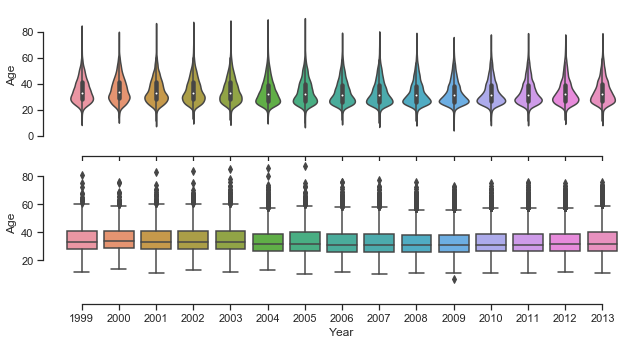

In [108]:
f, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
sns.set(style="ticks", palette="pastel")
sns.boxplot(x="Year", y="Age", data=df1, ax=axes[1])
sns.violinplot(x="Year", y="Age", data=df1, ax=axes[0])
sns.despine(offset=20, trim=True)

Box plots of the age distributions both by year and in aggregate seem to visually validate the presensence of outliers. As measures of mean are sensitive to the precense of outliers we must determine if the outliers need to be removed or if we need to use a method that does not really on mean when testing the null hypothesis that there is not significant difference in the distribution of ages over time. 

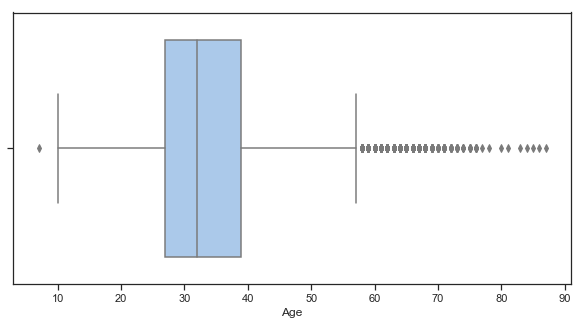

In [110]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df1["Age"])

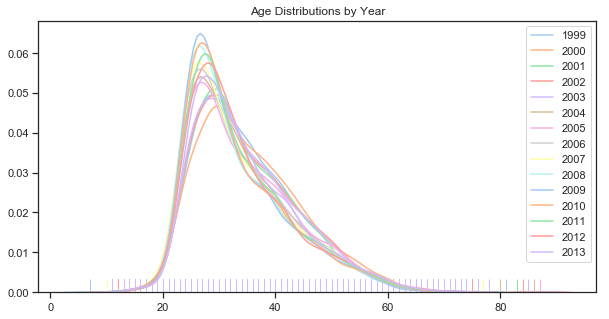

In [111]:
plt.figure(figsize=(10,5))
n = 1999
while n < 2014:
    YEAR = df1.loc[df1['Year'] == n]
    sns.distplot(YEAR[['Age']], hist=False, rug=True, label=n)
    n+=1
plt.title("Age Distributions by Year")
plt.legend()

Review of the distribution plots validate that "Age" among female runners is not normally distributed and variations of the mean of the distributions from year to year seems to be more pronouced in the distribution plots. While the distributions indicate that there may be a shift in mean age over time it is difficult to conclusively determine the direction of the shift.

Text(0.5,1,'Total Age Distribution')

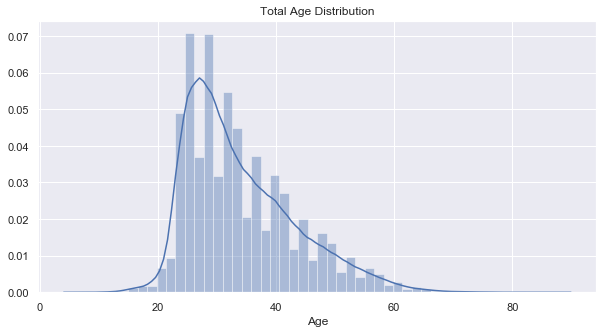

In [65]:
plt.figure(figsize=(10,5))
sns.distplot(df1['Age'])
plt.title("Total Age Distribution")

Review of the a kernel density plot seems to indicate that there is a change in the distrbution of "Age" over time. Additionally the plot seems to indicate a gradual increase in the density of runners under 30 years of age.

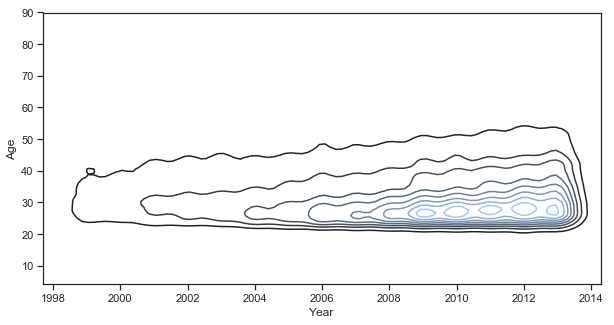

In [113]:
f, ax = plt.subplots(figsize=(10, 5))
sns.kdeplot(df1.Year, df1.Age, ax=ax)

By comparing the mean age by year to the median age by year the effects of the the outliers on mean age are more noticeable. When looking at the range of the age axis it appears that the range between the lowest mean and the highest mean is less than 3 years and the range between the lowest median and the highest median is about 3 years. Whether this variation is significant or not will be the determined in the statistical testing section of our analysis.   

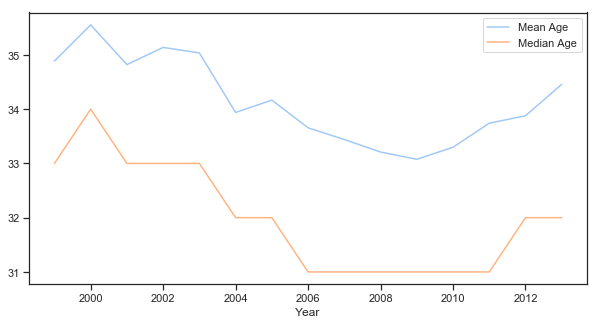

In [112]:
df1.groupby('Year')['Age'].mean().plot(kind='line', figsize=(10,5), label="Mean Age")
df1.groupby('Year')['Age'].median().plot(kind='line', figsize=(10,5),label="Median Age")
plt.legend()

The 20 ages with the lowest incidence rate were counted and plotted all together they accounted for only .12% of the the entire dataset. To analyze the impact of removing the outliers from the dataset a new data set was created that omitted all ages greater than 70 or less than 13. This was process was repeated with the lowest 25 and lowest 30 leading to new datasets that ommited .29% and .72% of the observations respectively. We chose this method because it detects anamolous data points on both sides of the mean and determines outliers by their frequency.

Text(0.5,0,'Age')

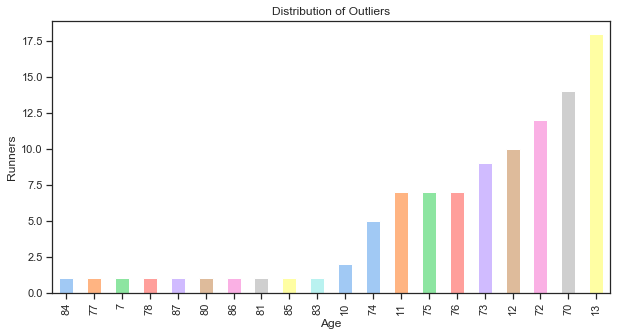

In [150]:
df1.Age.value_counts().nsmallest(20).plot(kind='bar', figsize=(10,5))
plt.title("Distribution of Outliers")
plt.ylabel("Runners")
plt.xlabel("Age")

In [149]:
df1.Age.value_counts().nsmallest(20).sum()/df1.Age.count()

0.0011721152618691176

In [66]:
df20 = df1[df1.Age < 70]
df20 = df20[df20.Age > 13]
df25 = df1[df1.Age < 67]
df25 = df25[df25.Age > 14]
df30 = df1[df1.Age < 63]
df30 = df30[df30.Age > 15]

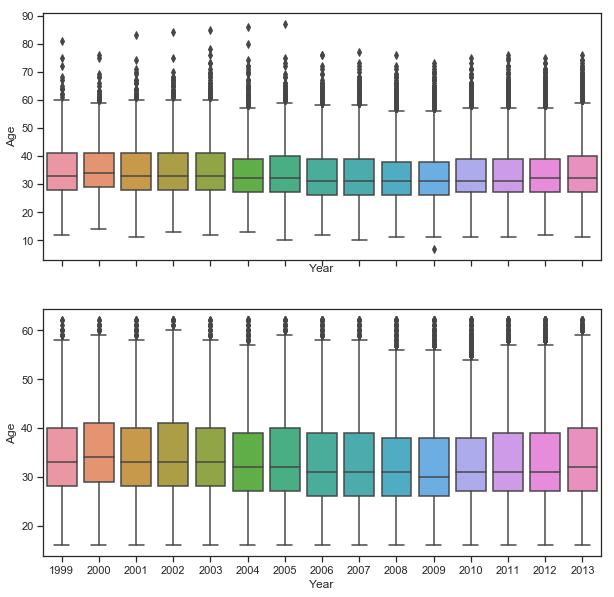

In [164]:
f, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
sns.boxplot(x="Year", y="Age", data=df1, ax=axes[0])
sns.boxplot(x="Year", y="Age", data=df30, ax=axes[1])

,Year,Age,Time
Year,1.000000,-0.033776,0.097660
Age,-0.033776,1.000000,0.133107
Time,0.097660,0.133107,1.000000


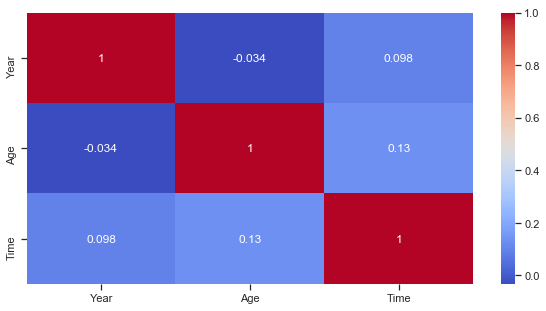

In [221]:
plt.figure(figsize=(10,5))
c= df1.corr()
sns.heatmap(c,cmap='coolwarm',annot=True)
c

Review of the correlation plot indicates a very weak negative correlation between year and age. Review of regression plot seems to indicate that overall the trend is for the average age to decrease over time. This trend is much more pronounced when only the mean age of each year is plotted.  

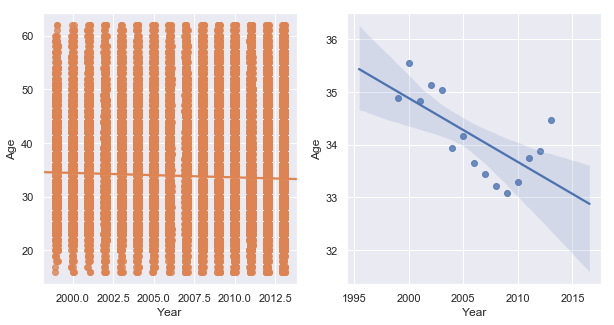

In [101]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5), sharey=False)
sns.regplot(x=g["Year"], y=g['Age'], ax=ax2)
sns.regplot(x=df30["Year"], y=df30['Age'],x_jitter=.1, ax=ax1)

However, when we look at the distribution of mean age for each year, there appears to be a change point in the data. To better capture this we plot a linear model plot with Locally Weighted Scatterplot Smoothing.This indicates that there may be a change point that occurs around 2009 where the general decrease in mean age starts an upward trend. Like all the other observations tests for statistical significance have to be conducted to validate the visual analysis. 

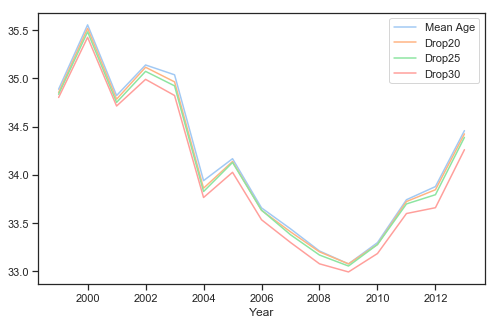

In [178]:
df1.groupby('Year')['Age'].mean().plot(kind='line', figsize=(8,5), label="Mean Age")
df20.groupby('Year')['Age'].mean().plot(kind='line', figsize=(8,5), label="Drop20")
df25.groupby('Year')['Age'].mean().plot(kind='line', figsize=(8,5), label="Drop25")
df30.groupby('Year')['Age'].mean().plot(kind='line', figsize=(8,5), label="Drop30")
plt.legend()

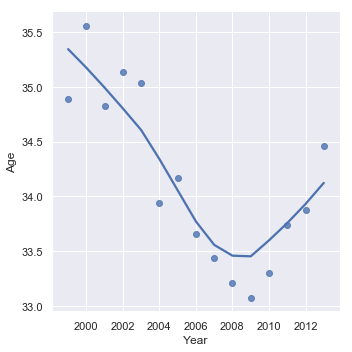

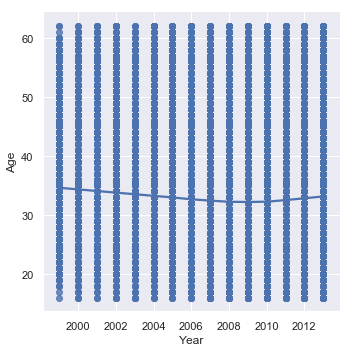

In [104]:
g = df1.groupby('Year')['Age'].mean().reset_index()
sns.lmplot(x="Year", y="Age", data=g, lowess=True)
sns.lmplot(x="Year", y="Age", data=df30,lowess=True)

In [220]:
df1[["Name","Pace","Time"]].describe()

,Time
count,86169.000000
mean,98.496626
std,14.393270
min,51.733333
25%,88.816667
50%,97.733333
75%,107.300000
max,177.516667


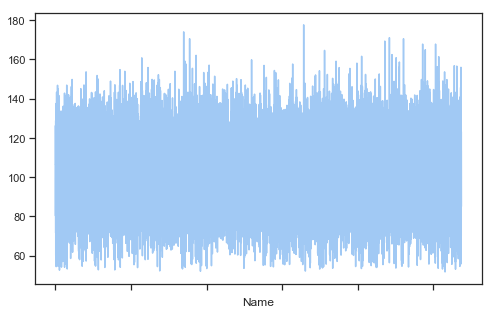

In [219]:
df1.groupby('Name')['Time'].mean().plot(kind='line', figsize=(8,5), label="Mean Time")

# Question of Interest
Has the age distribution of Female runners significantly changed over time? If so has the change occured over time or is there an evident break point?

## Hypothesis
    